# Google Trend Prediction: Enhancing Input Space with Seasons

In this notebook, I have attempted to improve the performances of a vanilla Fully-Connected Neural Network (FCNN) by allowing the model to learn the seasons. I have used one-hot encoding and embedding to convert the seasons into numbers. This notebook also uses the Google Trend results for the word *diet*.

In [1]:
# Readers interested in dowloanding the dataset from the internet can use the pytrends library

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./diet.csv', names=['date', 'diet'])
df = df[2:]
df.diet = df.diet.astype('int64')
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df2 = df[5:]

df2.plot()
plt.show()

# Preprocessing

Each version of the NN requires a different input space. Hence, I have introduced the *enrichMode* parameter in the *prep* function, which allows the user to enrich the input space for embedding and one hot encoding purposes. The current implementation is specificly designed for incorporating season information. When this option is not specified, the function only uses the past data in the input space. 

Any custom function implemented in this notebook can be accessed from the NeuralNetworks.py file accompanying this notebook. 

In [2]:
import NeuralNetworks
import importlib
importlib.reload(NeuralNetworks);

preperation = NeuralNetworks.Preprocessing(data=df2)
raw1 = preperation.prep(previous=5, future=1, normalize='minmax')

In [3]:
raw1[0]

(tensor([ 0.7073,  0.5854,  0.3902,  0.3659,  0.3171,  0.2927], dtype=torch.float64),
 tensor([ 0.1707], dtype=torch.float64))

For embedding purposes, I have encoded winter as 0, spring as 1, summer as 2 and fall as 3. The below example is from summer.

In [4]:
raw2 = preperation.prep(previous=5, future=1, enrichMode= 'embedding', normalize='minmax')

In [5]:
raw2[0]

(tensor([ 0.7073,  0.5854,  0.3902,  0.3659,  0.3171,  0.2927,  2.0000], dtype=torch.float64),
 tensor([ 0.1707], dtype=torch.float64))

The below dataset contains the one-hot encoding of the seasons. Each observation has 4 new variables which are either 0 or 1. For example, in the below example the third variable is 1 since it represents summer.    

In [6]:
raw3 = preperation.prep(previous=5, future=1, enrichMode= 'one-hot', normalize='minmax')

In [7]:
raw3[0]

(tensor([ 0.7073,  0.5854,  0.3902,  0.3659,  0.3171,  0.2927,  0.0000,
          0.0000,  1.0000,  0.0000], dtype=torch.float64),
 tensor([ 0.1707], dtype=torch.float64))

# Models

All of the models in this notebook use FCNN. The only difference between the models is I include seasonal information in the input space and I choose two different ways to achieve this. PyTorch's embedding function behaves like a look up table and returns values between -1 and 1 that are learned while training the model. These *latent variables* represent seasons in this dataset.

The architecture of the models is as following:
- **FCNN**: It has 6 input units, 20 and 15 hidden units in the first and second hidden layers and 1 output unit. This model is implemented by the *FCNet* function.  
- **FCNN with one-hot**: It has 10 input units (6 for the past observations, 4 for the one-hot encoding), 30 hidden units in two hidden layers and 1 output unit. This model also uses the *FCNet* function.  
- **FCNN with embedding**: It has 8 input units (6 for the past observations, 2 for the latent variables), 30 hidden units in the first hidden layer, 40 hidden units in the second hidden layer and 1 output unit. This model uses the *FCNetEmbed* function. 

I have experimented with different hyperparameters such as the number of hidden units, the activation function of the hidden layers, batch size and the learning rate to build a model with the strongest results. These experimentations are omitted from this notebook. I have found that using a different learning rate for each model improved the results.  

To compare the performance of these models, I will repeat training and prediction 50 times to minimize the impact of random initializations on the results.

# Results

In [8]:
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import numpy as np

inputSize = 6
num_epochs=60
batch_size=36
repeat = 50
results = pd.DataFrame(columns=['FCNN', 'HOT', 'EMBED'])

loss=F.mse_loss

for i in range(repeat):
    temp = pd.DataFrame(np.nan, index=[0], columns=['FCNN', 'HOT', 'EMBED'])
    
    FCNN = NeuralNetworks.FCNet(units=[inputSize, 20, 15, 1], activation=F.tanh)
    HOT = NeuralNetworks.FCNet(units=[inputSize+4, 30, 30, 1], activation=F.tanh)
    EMBED = NeuralNetworks.FCNetEmbed(cont_idx=list(range(0,inputSize)), cat_idx=[inputSize], activation=F.tanh, 
                                      embed_detail=[(4,2)], units=[inputSize+2, 30, 40, 1])
    
    for idx, (model, dat, lr) in enumerate([(FCNN, raw1, 0.05), (HOT, raw3, 0.02), (EMBED, raw2, 0.01)]):
        train_loader = data.DataLoader(dataset=dat[0:120], batch_size=batch_size, shuffle=False)
        test_loader = data.DataLoader(dataset=dat[120:170], batch_size=1, shuffle=False)
        
        Processing = NeuralNetworks.Processing(model=model, epochs = num_epochs, 
                                                opt = optim.Adam(model.parameters(), lr=lr), loss=loss)
        Processing.train(train_loader=train_loader)
        
        _, rmse = Processing.test(test_loader=test_loader)
        
        temp.iloc[0, idx] = rmse
    
    results = results.append(temp)

results = results.reset_index(drop=True);

Below values are the mean RMSE for vanilla, one-hot encoding and embedding FCNN. It seems adding the season information does not improve the results.

In [9]:
[x**0.5 for x in results.mean()] 

[0.1823045255971868, 0.14338438845837403, 0.14485429415785103]

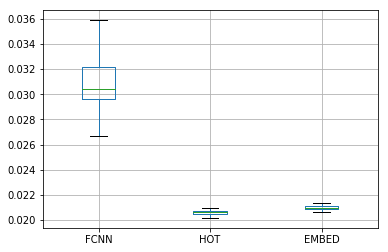

In [10]:
results.boxplot(showfliers=False)
plt.show()

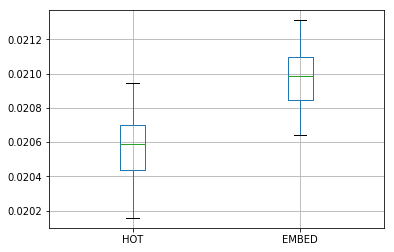

In [11]:
results.loc[:,['HOT', 'EMBED']].boxplot(showfliers=False)
plt.show()

In [12]:
import scipy.stats
print(scipy.stats.ttest_ind(results.FCNN, results.HOT))
print(scipy.stats.ttest_ind(results.FCNN, results.EMBED))
print(scipy.stats.ttest_ind(results.HOT, results.EMBED))

Ttest_indResult(statistic=13.323404607790922, pvalue=1.0032644980229774e-23)
Ttest_indResult(statistic=12.882149356613025, pvalue=8.298454139224497e-23)
Ttest_indResult(statistic=-10.513779851490922, pvalue=9.31380371559018e-18)


The t-test shows that models using one-hot encoding and embedding improve the vanilla model. Furthermore, one-hot encoding performs better then embedding. I am suprised by these reults, as I was expecting embeddings to out perform one-hot encodding since embeddings learns a 2 dimensional representation of the seasons allowing a more complex understanding. Additionally experiments might be required for embeddings.

When experimenting with number of previous observations to include in the model, I have observed that including additional information does not always improve results. For example, models using the past 5 observations perform better than models using the past 7 observations. I do not know what to make of this, but I will analyze this in more detail in a future notebook.

# Next Steps

In the next iteration of this notebook, I will look into following models/improvements:
* Recurrent Neural Networks (with and/or without LSTM)
* Residual learning
* Different fusions of model (CNN + RNN + Embedding)